In [299]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [300]:
train_dataset_path = 'dataset/train'
all_subjects = sorted(os.listdir(train_dataset_path))

data_frames = []
target_data_frames = []

for subject_folder in all_subjects:
    subject_path = os.path.join(train_dataset_path, subject_folder)
    
    if os.path.isdir(subject_path):
        csv_files = sorted([f for f in os.listdir(subject_path) if f.endswith('.csv')])
        
        if len(csv_files) >= 2:
            first_csv = csv_files[0]
            target_csv = csv_files[1]
            
            # Input signal
            full_path = os.path.join(subject_path, first_csv)
            df = pd.read_csv(full_path, header=None).T
            data_frames.append(df)
            
            # Target values
            target_val_path = os.path.join(subject_path, target_csv)
            target_df = pd.read_csv(target_val_path, header=None).T
            target_df = target_df.drop(index=0).reset_index(drop=True)  # drop first row
            target_data_frames.append(target_df)

# Combine all subject data
train_data_full = pd.concat(data_frames, ignore_index=True)

target_values = pd.concat(target_data_frames, ignore_index=True)


In [301]:
print(train_data_full.shape)
train_data_full.head()


(46, 54240)


,0,1,2,3,4,5,6,7,8,9,...,54230,54231,54232,54233,54234,54235,54236,54237,54238,54239
0,517,519,520,520,520,519,517,513,509,502,...,484,481,484,470,467,470,466,462,458,464
1,504,503,506,506,508,508,511,514,516,517,...,464,469,477,487,493,502,512,522,525,534
2,488,489,487,487,486,484,484,484,484,486,...,271,256,245,240,239,239,239,244,248,259
3,646,652,652,653,650,645,637,626,616,604,...,525,524,524,524,525,522,520,521,521,521
4,467,469,467,472,469,471,476,479,482,484,...,482,479,475,471,468,464,464,460,459,458


In [302]:
print(target_values.shape)
target_values.head()

(46, 8)


,0,1,2,3,4,5,6,7
0,13.02,14.80,15.16,15.20,15.20,15.20,15.22,15.22
1,12.82,14.77,15.05,15.11,15.09,15.03,15.03,15.11
2,13.03,14.80,15.07,15.11,15.12,15.12,15.12,15.12
3,13.03,14.80,15.07,15.11,15.03,15.12,15.12,15.12
4,12.87,14.59,15.05,13.90,14.99,15.09,15.11,15.12


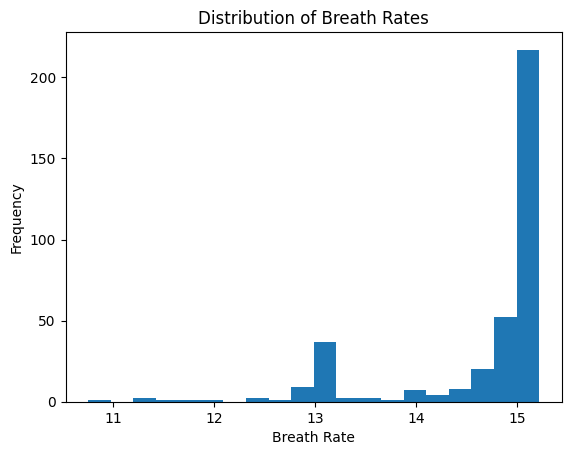

In [303]:
import matplotlib.pyplot as plt

plt.hist(target_values.values.flatten(), bins=20)
plt.title("Distribution of Breath Rates")
plt.xlabel("Breath Rate")
plt.ylabel("Frequency")
plt.show()


In [304]:
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=1, hidden_size=256, batch_first=True)
        self.linear1 = torch.nn.Linear(256, 64)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear2 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):  # x: (B, 6780, 1)
        h_t, _ = self.lstm(x)
        h_t = h_t[:, -1, :]  # Last time step
        x = self.linear1(h_t)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x.view(-1)  # (B,)


In [305]:
class BreathRateDataset(torch.utils.data.Dataset):
    def __init__(self, signals_df, targets_df, window_size=6780, target_mean=0.0, target_std=1.0):
        self.signals = signals_df.values.astype(np.float32)  # shape: (N, 54240)
       
        self.targets = targets_df.values.astype(np.float32)  # shape: (N, 8)
        self.window_size = window_size
        self.target_mean = target_mean
        self.target_std = target_std
   
        assert self.signals.shape[1] == 8 * window_size

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx].reshape(8, self.window_size, 1)
        target = self.targets[idx]
        target = (target - self.target_mean) / self.target_std  # normalize
        return torch.tensor(signal), torch.tensor(target, dtype=torch.float32)


In [306]:
train_data, validation_data, train_target, validation_target = train_test_split(train_data_full, target_values, test_size=1/6, shuffle=True )

In [307]:
train_dataset = BreathRateDataset(train_data, train_target ,6780)
validation_dataset = BreathRateDataset(validation_data, validation_target , 6780)

In [308]:
x,y = train_dataset[0]
x.shape

torch.Size([8, 6780, 1])

In [309]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 1)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 1)

In [310]:
from torch.amp import autocast, GradScaler
from tqdm import tqdm

def train(model, lossfn, optimizer, device, dataloader, scaler):
    model.train()
    total_loss, total_samples = 0.0, 0

    for xb, yb in tqdm(dataloader, desc="Training"):
        # print(xb.shape)
        B, N, W,_ = xb.shape  # B = batch size (subjects), N = 8 intervals
        xb = xb.view(B * N, W, 1).to(device)     # (B×8, 6780, 1)
        yb = yb.view(B * N).to(device)           # (B×8,)

        optimizer.zero_grad()

        with autocast('cuda'):
            preds = model(xb)  # (B×8,)
            preds.squeeze(-1)
            loss = lossfn(preds, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += torch.sum((preds - yb) ** 2).item()
        total_samples += len(yb)

    rmse = (total_loss / total_samples) ** 0.5
    print(f"\nTrain RMSE: {rmse:.4f}")
    return rmse

@torch.no_grad()
def validate(model, lossfn, device, dataloader):
    model.eval()
    total_loss, total_samples = 0.0, 0

    for xb, yb in dataloader:
        B, N, W, _ = xb.shape
        xb = xb.view(B * N, W, 1).to(device)
        yb = yb.view(B * N).to(device)

        preds = model(xb)
        preds.squeeze(-1)
        loss = lossfn(preds, yb)
        
        total_loss += torch.sum((preds - yb) ** 2).item()
        total_samples += len(yb)

    rmse = (total_loss / total_samples) ** 0.5
    print(f"\nValidation RMSE: {rmse:.4f}")
    return rmse



In [311]:
# import numpy as np

# # Assume train_targets is a DataFrame of shape (n_subjects, 8)
# flat_targets = train_target.values.flatten()

# # Create histogram
# hist, bin_edges = np.histogram(flat_targets, bins=20)
# bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# # Compute inverse frequency weights
# inv_freq = 1.0 / (hist + 1e-6)
# inv_freq = inv_freq / inv_freq.sum()  # Normalize so weights don't explode
# # Store for lookup
# def compute_weight(y):
#     # y: numpy array of target values
#     bin_idx = np.digitize(y, bin_edges) - 1
#     bin_idx = np.clip(bin_idx, 0, len(inv_freq) - 1)
#     return inv_freq[bin_idx]


In [312]:
# import torch

# def weighted_mse(preds, targets):
#     y_np = targets.detach().cpu().numpy()
#     weights = torch.tensor(compute_weight(y_np), dtype=torch.float32, device=targets.device)
#     return (weights * (preds - targets) ** 2).mean()


In [327]:
model = LSTM().to(device)
model = torch.compile(model)
lossfn = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()
# scheduler = None 
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=7, threshold=1e-2, verbose = True)

In [328]:
epochs = 10
best_rmse = float("inf")
wait = 0
patience = 3

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    train_rmse = train(model, lossfn, optimizer, device, train_dataloader, scaler)
    val_rmse = validate(model, lossfn, device, validation_dataloader)

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), "best_model_breath.pth")
        print("Saved best model.")
        wait = 0
    else:
        wait += 1
        print(f"No improvement. Patience: {wait}/{patience}")
        torch.save(model.state_dict(), "best_model_breath.pth")
        if wait >= patience:
            print("Early stopping.")
            break



Epoch 1


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:19<00:00,  1.90it/s]



Train RMSE: 13.0100

Validation RMSE: 8.5296
Saved best model.

Epoch 2


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.01it/s]



Train RMSE: 4.4732

Validation RMSE: 1.1105
Saved best model.

Epoch 3


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.05it/s]



Train RMSE: 3.0688

Validation RMSE: 1.2468
No improvement. Patience: 1/3

Epoch 4


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.02it/s]



Train RMSE: 2.9702

Validation RMSE: 0.9167
Saved best model.

Epoch 5


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:19<00:00,  1.92it/s]



Train RMSE: 2.9927

Validation RMSE: 0.9792
No improvement. Patience: 1/3

Epoch 6


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.03it/s]



Train RMSE: 3.1226

Validation RMSE: 0.8849
Saved best model.

Epoch 7


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.02it/s]



Train RMSE: 2.6691

Validation RMSE: 1.0520
No improvement. Patience: 1/3

Epoch 8


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.03it/s]



Train RMSE: 2.8404

Validation RMSE: 1.1389
No improvement. Patience: 2/3

Epoch 9


Training: 100%|████████████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.02it/s]



Train RMSE: 2.7811

Validation RMSE: 0.9662
No improvement. Patience: 3/3
Early stopping.


In [329]:
test_dataset_path = 'dataset/test'
all_subjects = sorted(os.listdir(test_dataset_path))

data_frames = []
target_data_frames = []

for subject_folder in all_subjects:
    subject_path = os.path.join(test_dataset_path, subject_folder)
    
    if os.path.isdir(subject_path):
        csv_files = sorted([f for f in os.listdir(subject_path) if f.endswith('.csv')])
        
        if len(csv_files) >= 2:
            first_csv = csv_files[0]
            target_csv = csv_files[1]
            
            # Input signal
            full_path = os.path.join(subject_path, first_csv)
            df = pd.read_csv(full_path, header=None).T
            data_frames.append(df)
            
            # Target values
            target_val_path = os.path.join(subject_path, target_csv)
            target_df = pd.read_csv(target_val_path, header=None).T
            target_df = target_df.drop(index=0).reset_index(drop=True)  # drop first row
            target_data_frames.append(target_df)

# Combine all subject data
test_data_full = pd.concat(data_frames, ignore_index=True)
target_values = pd.concat(target_data_frames, ignore_index=True)


In [330]:
test_dataset = BreathRateDataset(test_data_full, target_values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


In [331]:
from tqdm import tqdm

def predict_and_evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Testing"):
            B, N, W ,_= xb.shape  # (1, 8, 6780)
            xb = xb.view(B * N, W, 1).to(device)       # (8, 6780, 1)
            yb = yb.view(B * N).to(device)             # (8,)

            preds = model(xb).view(-1)    # (8,)
            # preds = preds * target_std + target_mean
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(yb.cpu().numpy())
            
            total_loss += torch.sum((preds - yb) ** 2).item()
            total_samples += B * N

    rmse = (total_loss / total_samples) ** 0.5
    print(f"\nTest RMSE: {rmse:.4f}")
    return all_preds, all_targets, rmse


In [332]:
model.load_state_dict(torch.load("best_model_breath.pth"))  # if saved
model.to(device)
all_preds, all_targets, test_rmse = predict_and_evaluate(model, test_loader, device)


Testing: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.12it/s]


Test RMSE: 0.9403


In [341]:
all_preds[9] , all_targets[9]

(np.float32(14.391564), np.float32(14.59))